<a href="https://colab.research.google.com/github/castrokelly/MBA/blob/main/KellyCastro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## MBA em Ciência de Dados
# Redes Neurais e Aprendizado Profundo

## <span style="color:darkred">Avaliação Final - 2024 : Enuncaido</span>

Moacir Antonelli Ponti

CeMEAI - ICMC/USP São Carlos

---

Nessa avaliação será utilizado o dataset `imdb-reviews-pt-br.csv` que contém avaliações de filmes realizadas no site IMDB, com textos em português e em inglês. O alvo do dataset é a coluna `sentiment` que contém o sentimento relacionado à avaliação: positivo ou negativo.

Vamos explorar um sentence embedding pré-treinado para multiplos idiomas, e avaliar redes neurais comparando-as com relação aos textos em inglês e português.

As tarefas a realizar são as seguintes:

Preparação:
1. **Instalar o pacote** `sentence_transformers` e **carregar o modelo** 'stsb-xlm-r-multilingual' para geração de sentence embeddings, conforme mostrado no código abaixo.
2. **Carregar a base de dados** e obter uma amostra de 12 mil linhas (use o método `sample` do dataframe pandas).
3. **Gerar os embeddings** usando o método encode, para os textos em português e em inglês. Ver https://www.sbert.net/examples/applications/computing-embeddings/README.html para mais detalhes. OBS: pode demorar um pouco
4. **Separar dados** 75% para treinamento, 25% para teste usando `train_test_split`, sendo a mesma partição para ingles e portugues.

Modelos:
1.  (1,0 pt) **Modelo A**: projete e treine uma rede neural profunda densa, utilizando como entrada os embeddings pré-treinados dos dados em **portugues** para análise de sentimento (classificação binária).<br>
    * A arquitetura deve ter portanto as seguintes camadas:
        * entrada
        * normalização em batch
        * densa 768 neurônios, relu
        * densa 512 neurônios, relu
        * densa 256 neurônios, ativação linear
        * normalização em batch
        * ativação relu
        * dropout 0.375
        * densa 1 neurônio, sigmoide
    * Utilizar Adam com taxa de aprendizado inicial de 0.0007 e com decaimento em todas as épocas exponencial a -0.09
    * Treinar com perda entropia cruzada por 15 épocas com batch size 20
    * Compute como métricas, além da perda, a área sob a curva ROC (AUC ROC) e a Acurácia Binária (ver https://www.tensorflow.org/api_docs/python/tf/keras/metrics)<br><br>

2.  (1,0 pt) **Modelo B**: projete e treine uma rede neural profunda densa, utilizando como entrada os *textos tokenizados* em **português** para análise de sentimento (classificação binária).<br>
    * A arquitetura deve ter portanto as seguintes camadas:
        * entrada
        * camada embedding com max_words=5000 e dimensão do embedding de tamanho 386
        * camada convolucional 1d com 64 neuronios de tamanho 2 e padding='same', ativação relu
        * camada LSTM 512 neurônios, sem especificar ativação (manter a default)
        * densa 256 neurônios, ativação linear
        * normalização em batch
        * ativação relu
        * dropout 0.375
        * densa 1 neurônio, sigmoide
    * Utilizar os mesmos hiper-parâmetros de otimização, treinamento e métricas do modelo anterior<br><br>


3. (2,0 pt) **Avalie as rede neurais de classificação** (Modelos A e B):
    * Exiba o gráfico das métricas ROC AUC e Accuracy calculadas no treinamento ao longo das épocas para o modelos A e B
    * Calcule e exiba as métricas no conjunto de teste usando o cada modelo</br>
    3.1 (2,0 pt) **Conclua** sobre os resultados obtidos nos seus experimentos, conforme descrito abaixo no notebook.</br></br>

4. (3,0 pt) **Fine-tuning** dos Modelo B com os dados em inglês, treinando por 15 épocas e batch_size=20, com Adam e taxa de aprendizado 0.00001 (sem decaimento):
    1. Modelo Fine Tuning versão 1: realize ajuste fino, congelando a camada de embeddings,
    2. Modelo Fine Tuning versão 2: realize ajuste fino, congelando a camada convolucional e a camada LSTM.
        
    * exibir a função de custo ao longo das épocas de treinamento para cada modelo,
    * calcular e exibir métricas dos modelos após fine-tuning usando o conjunto de teste em ingles (textos tokenizados)</br>
    4.1 (1,0 pt) **Conclua** sobre os resultados obtidos nos seus experimentos, conforme descrito abaixo no notebook.</br></br>

5. **Bônus:** (+1 ponto extra)
    * *Análise visual das características*: visualize scatterplots com os 2 dimensões obtidos com o método tSNE as classes dos exemplos atribuídas com cores ou marcadores diferentes:
        1. scatterplot com projeção tSNE do conjunto de teste referente ao embedding pré-treinado em português,
        1. scatterplot com projeção tSNE da última camada densa de 256 dimensões extraído do conjunto de teste tokenizado em português referente ao *Modelo B*,
        1. scatterplot com projeção tSNE da última camada densa de 256 dimensões extraído do conjunto de teste em inglês (tokens) referente ao *Modelo B* após ajuste fino versão 2.
    * Escreva comentários com suas conclusões sobre a análise visual.

## Preparação

### 1. Carregar bibliotecas e modelo pré-treinado SentenceTransformer

In [51]:
# Instalação do pacote necessário para embeddings pré-treinados
!pip install sentence-transformers

In [54]:
# Importação das bibliotecas
#Bibliotecas gerais
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Bibliotecas de Machine Learning
import tensorflow as tf

from numpy.random import seed

from tensorflow.random import set_seed
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential

from sklearn.model_selection import train_test_split

# Modelo de embeddings pré-treinados
from sentence_transformers import SentenceTransformer

#### Verifique a versão do Tensorflow, recomendamos a 2.17.
OBS: o código pode ter problemas com a versão 2.18

In [3]:
print(tf.__version__)

2.17.1


In [4]:
# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [5]:
# baixar modelo codificador de setenças
model = SentenceTransformer('stsb-xlm-r-multilingual')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/709 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/505 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

### 2. Carregar base de dados e obter amostra

In [6]:
!gdown 1ltAAPcaPD1epgs-F9i-nhaF350DPPrGK

# ler base de dados
df_orig = pd.read_csv("imdb-reviews-pt-br.csv", delimiter=',', engine='python')

Downloading...
From (original): https://drive.google.com/uc?id=1ltAAPcaPD1epgs-F9i-nhaF350DPPrGK
From (redirected): https://drive.google.com/uc?id=1ltAAPcaPD1epgs-F9i-nhaF350DPPrGK&confirm=t&uuid=941eed2d-c534-4cf4-9b5c-02fca35d5746
To: /content/imdb-reviews-pt-br.csv
100% 127M/127M [00:01<00:00, 77.9MB/s]


In [7]:
# obter amostra
df = df_orig.sample(12000).reset_index(drop=True)
df.sentiment.value_counts()

,count
sentiment,
neg,6058
pos,5942


### 3. Separar dados em treinamento e teste e preparar rótulos

Iremos também verificar o tamanho das strings em cada instancia, para considerar apenas um número de caracteres proporcional ao percentil 80.

In [8]:
# rotulos
y = np.array((df.sentiment=='pos').astype(int))

X_train_txt_en, X_test_txt_en, y_train_en, y_test_en= train_test_split(df.text_en.values, y, test_size=0.25, random_state=51)
X_train_txt_pt, X_test_txt_pt, y_train_pt, y_test_pt= train_test_split(df.text_pt.values, y, test_size=0.25, random_state=51)

sum(y_train_en!=y_train_pt)

0

In [9]:
# tamanhos das strings - usaremos o percentil 80 como tamanho da entrada máximo
num_words = df.text_pt.apply(lambda x: len(str(x).split()))
max_length = num_words.max()
percentile_80 = num_words.quantile(0.80)
percentile_95 = num_words.quantile(0.95)

print(f"percentil 80.0: {percentile_80}")
print(f"percentil 95.0: {percentile_95}")
print(f"Maximo: {max_length}")

percentil 80.0: 306.0
percentil 95.0: 545.0499999999993
Maximo: 955


### 4. Geração dos embeddings

Utilizar o encoder carregado para obter os embeddings para treinamento e teste em Português e Inglês, separadamente.

Exemplo de uso: `model.encode(texto, batch_size=16, show_progress_bar=True)`

In [43]:
X_train_emb_en = model.encode(X_train_txt_en, batch_size=16, show_progress_bar=True)
X_test_emb_en = model.encode(X_test_txt_en, batch_size=16, show_progress_bar=True)

# Exibição das dimensões dos embeddings para validação
print(f"Formato dos embeddings para treino em inglês: {X_train_emb_en.shape}")
print(f"Formato dos embeddings para teste em inglês: {X_test_emb_en.shape}")

Batches:   0%|          | 0/563 [00:00<?, ?it/s]

Batches:   0%|          | 0/188 [00:00<?, ?it/s]

Formato dos embeddings para treino em inglês: (9000, 768)
Formato dos embeddings para teste em inglês: (3000, 768)


In [44]:
# Geração dos embeddings para textos em português
X_train_emb_pt = model.encode(X_train_txt_pt, batch_size=16, show_progress_bar=True)
X_test_emb_pt = model.encode(X_test_txt_pt, batch_size=16, show_progress_bar=True)

# Exibição das dimensões dos embeddings para validação
print(f"Formato dos embeddings para treino em português: {X_train_emb_pt.shape}")
print(f"Formato dos embeddings para teste em português: {X_test_emb_pt.shape}")


Batches:   0%|          | 0/563 [00:00<?, ?it/s]

Batches:   0%|          | 0/188 [00:00<?, ?it/s]

Formato dos embeddings para treino em português: (9000, 768)
Formato dos embeddings para teste em português: (3000, 768)


5. Tokenização do texto

Definiremos um número máximo de palavras e um tamanho máximo de sequência com base nos dados em Português, conforme abaixo.

In [13]:
max_words = 5000  # Numero maximo de palavras
max_sequence_length = int(percentile_80)  # Tamanho maximo da sequencia igual ao percentil 80

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train_txt_pt)

sequences_train = tokenizer.texts_to_sequences(X_train_txt_pt)
sequences_test = tokenizer.texts_to_sequences(X_test_txt_pt)

# realizar padding para igualar sentencas
X_train_tok_pt = pad_sequences(sequences_train, maxlen=max_sequence_length)
X_test_tok_pt = pad_sequences(sequences_test, maxlen=max_sequence_length)

In [14]:
# Tokenização dos textos em inglês usando os mesmos parâmetros do português
sequences_train_en = tokenizer.texts_to_sequences(X_train_txt_en)
sequences_test_en = tokenizer.texts_to_sequences(X_test_txt_en)

# Padding para igualar as sequências
X_train_tok_en = pad_sequences(sequences_train_en, maxlen=max_sequence_length)
X_test_tok_en = pad_sequences(sequences_test_en, maxlen=max_sequence_length)

# Exibição para validação
print(f"Formato das sequências tokenizadas para treino: {X_train_tok_en.shape}")
print(f"Formato das sequências tokenizadas para teste: {X_test_tok_en.shape}")


Formato das sequências tokenizadas para treino: (9000, 306)
Formato das sequências tokenizadas para teste: (3000, 306)


---

## Tarefas

Definimos os modelos e iniciamos as tarefas. O código abaixo é uma referência para auxiliar na resolução, complete/altere conforme necessário.

In [55]:
# DICA: use keras.layers.CAMADA para montar as arquiteturas

# definir modelo A
def model_A(input_dim, dropout_rate=0.375):
    """
    Modelo A: Rede neural densa para classificação binária.
    Utiliza embeddings como entrada.

    Args:
        input_dim (int): Dimensão dos embeddings de entrada.
        dropout_rate (float): Taxa de dropout. Default: 0.375.

    Returns:
        keras.Model: Modelo compilado.
    """
    input_data = keras.layers.Input(shape=(input_dim,))
    x = keras.layers.BatchNormalization()(input_data)
    x = keras.layers.Dense(768, activation='relu')(x)
    x = keras.layers.Dense(512, activation='relu')(x)
    x = keras.layers.Dense(256, activation='linear')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Dropout(dropout_rate)(x)
    output = keras.layers.Dense(1, activation='sigmoid')(x)

    dnn = keras.models.Model(input_data, output)
    return dnn


In [56]:
# definir modelo B
def model_B(input_dim, max_words=5000, embedding_dim=386, code_dim=256, dropout_rate=0.375):
    """
    Modelo B: Rede neural com CNN e LSTM para classificação binária.
    Utiliza textos tokenizados como entrada.

    Args:
        input_dim (int): Tamanho máximo da sequência.
        max_words (int): Número máximo de palavras no vocabulário.
        embedding_dim (int): Dimensão do embedding. Default: 386.
        code_dim (int): Dimensão da camada densa intermediária. Default: 256.
        dropout_rate (float): Taxa de dropout. Default: 0.375.

    Returns:
        keras.Model: Modelo compilado.
    """
    input_layer = keras.layers.Input(shape=(input_dim,))
    embedding_layer = keras.layers.Embedding(max_words, embedding_dim, name='embedding')(input_layer)
    conv_layer = keras.layers.Conv1D(64, 2, padding='same', activation='relu')(embedding_layer)
    lstm_layer = keras.layers.LSTM(512)(conv_layer)
    dense_layer = keras.layers.Dense(code_dim, activation='linear')(lstm_layer)
    batch_norm_layer = keras.layers.BatchNormalization()(dense_layer)
    activation_layer = keras.layers.Activation('relu')(batch_norm_layer)
    dropout_layer = keras.layers.Dropout(dropout_rate)(activation_layer)
    output_layer = keras.layers.Dense(1, activation='sigmoid')(dropout_layer)

    model = keras.models.Model(inputs=input_layer, outputs=output_layer)
    return model


In [57]:
epochs = 15
batch_size = 20
lrate = 0.0007

---

### 1. (1,0 pt) Modelo A: classificador de sentimento em *portugues* usando embedding pré-treinado

In [48]:
seed(1)
set_seed(2)

def scheduler(epoch, lr):
    return float(lr * tf.math.exp(-0.09))

callbacklr = tf.keras.callbacks.LearningRateScheduler(scheduler)

# instanciar, compilar e treinar modelo A

In [19]:
# Instanciar o Modelo A para embeddings em português
dnn = model_A(input_dim=X_train_emb_pt.shape[1])

In [20]:
# Configurar o otimizador e compilar o modelo
optimizer = keras.optimizers.Adam(learning_rate=lrate)
dnn.compile(optimizer=optimizer, loss='binary_crossentropy',
            metrics=[tf.keras.metrics.AUC(name='auc'), 'accuracy'])

In [21]:
# Treinar o modelo A com embeddings em português
history = dnn.fit(
    X_train_emb_pt, y_train_pt,
    validation_data=(X_test_emb_pt, y_test_pt),
    epochs=epochs, batch_size=batch_size,
    callbacks=[callbacklr]
)

Epoch 1/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.7274 - auc: 0.7977 - loss: 0.5882 - val_accuracy: 0.7873 - val_auc: 0.8681 - val_loss: 0.4716 - learning_rate: 6.3975e-04
Epoch 2/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7958 - auc: 0.8733 - loss: 0.4505 - val_accuracy: 0.7880 - val_auc: 0.8747 - val_loss: 0.4608 - learning_rate: 5.8469e-04
Epoch 3/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8204 - auc: 0.8993 - loss: 0.4022 - val_accuracy: 0.7840 - val_auc: 0.8717 - val_loss: 0.4735 - learning_rate: 5.3437e-04
Epoch 4/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8515 - auc: 0.9275 - loss: 0.3423 - val_accuracy: 0.7860 - val_auc: 0.8711 - val_loss: 0.5008 - learning_rate: 4.8837e-04
Epoch 5/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8843 - auc: 0.9527 - loss: 0.2794 - val_accuracy: 0.7693 - val_auc: 0.8599 - val_loss: 0.5909 - learning_rate: 4.4634e-04
Epoch 6/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accura

In [22]:
# Avaliar o Modelo A em português
results_a_pt = dnn.evaluate(X_test_emb_pt, y_test_pt, verbose=0)
print(f"Modelo A - Resultados em português:")
print(f"Loss: {results_a_pt[0]}, AUC: {results_a_pt[1]}, Accuracy: {results_a_pt[2]}")

Modelo A - Resultados em português:
Loss: 1.1860754489898682, AUC: 0.8474308848381042, Accuracy: 0.7933333516120911


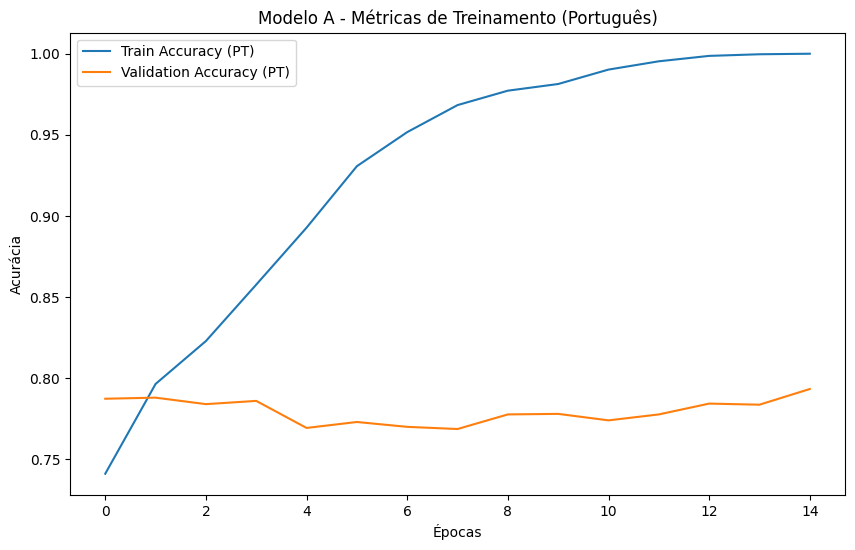

In [23]:
# Visualização das métricas para o treinamento em português
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy (PT)')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy (PT)')
plt.title("Modelo A - Métricas de Treinamento (Português)")
plt.xlabel("Épocas")
plt.ylabel("Acurácia")
plt.legend()
plt.show()

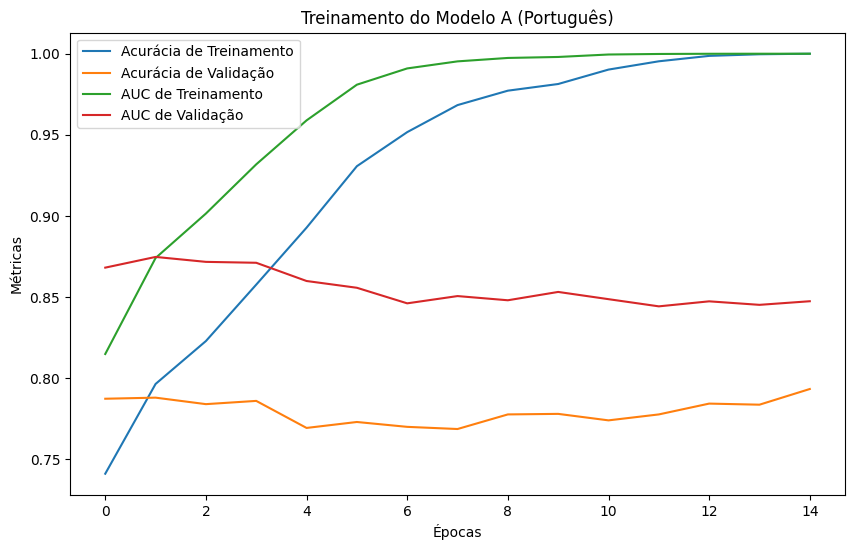

In [59]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Acurácia de Treinamento')
plt.plot(history.history['val_accuracy'], label='Acurácia de Validação')
plt.plot(history.history['auc'], label='AUC de Treinamento')
plt.plot(history.history['val_auc'], label='AUC de Validação')
plt.title("Treinamento do Modelo A (Português)")
plt.xlabel("Épocas")
plt.ylabel("Métricas")
plt.legend()
plt.show()


###Overfitting Evidente:

* A acurácia de treinamento alcança valores próximos de `1`, enquanto a acurácia de validação estabiliza em torno de `0.77`. Isso indica `overfitting`.
* O mesmo é observado na curva de AUC.

In [60]:
# Instanciar o Modelo A com taxa de dropout maior para reduzir overfitting
dnn = model_A(input_dim=X_train_emb_pt.shape[1], dropout_rate=0.5)

# Configurar o otimizador e compilar o modelo
optimizer = keras.optimizers.Adam(learning_rate=lrate)
dnn.compile(optimizer=optimizer, loss='binary_crossentropy',
            metrics=[tf.keras.metrics.AUC(name='auc'), 'accuracy'])

# Treinar o Modelo A
history = dnn.fit(X_train_emb_pt, y_train_pt,
                  validation_data=(X_test_emb_pt, y_test_pt),
                  epochs=epochs, batch_size=batch_size,
                  callbacks=[callbacklr])


Epoch 1/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7188 - auc: 0.7920 - loss: 0.6025 - val_accuracy: 0.7790 - val_auc: 0.8693 - val_loss: 0.4711 - learning_rate: 6.3975e-04
Epoch 2/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7926 - auc: 0.8684 - loss: 0.4591 - val_accuracy: 0.7847 - val_auc: 0.8728 - val_loss: 0.4617 - learning_rate: 5.8469e-04
Epoch 3/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8215 - auc: 0.8985 - loss: 0.4020 - val_accuracy: 0.7830 - val_auc: 0.8712 - val_loss: 0.4723 - learning_rate: 5.3437e-04
Epoch 4/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8405 - auc: 0.9205 - loss: 0.3587 - val_accuracy: 0.7783 - val_auc: 0.8668 - val_loss: 0.5043 - learning_rate: 4.8837e-04
Epoch 5/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8727 - auc: 0.9456 - loss: 0.2977 - val_accuracy: 0.7703 - val_auc: 0.8589 - val_loss: 0.5658 - learning_rate: 4.4634e-04
Epoch 6/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accura

In [61]:
# Avaliar novamente Modelo A em português
results_a_pt = dnn.evaluate(X_test_emb_pt, y_test_pt, verbose=0)
print(f"Modelo A - Resultados em português:")
print(f"Loss: {results_a_pt[0]}, AUC: {results_a_pt[1]}, Accuracy: {results_a_pt[2]}")

Modelo A - Resultados em português:
Loss: 1.2473756074905396, AUC: 0.8343900442123413, Accuracy: 0.7733333110809326


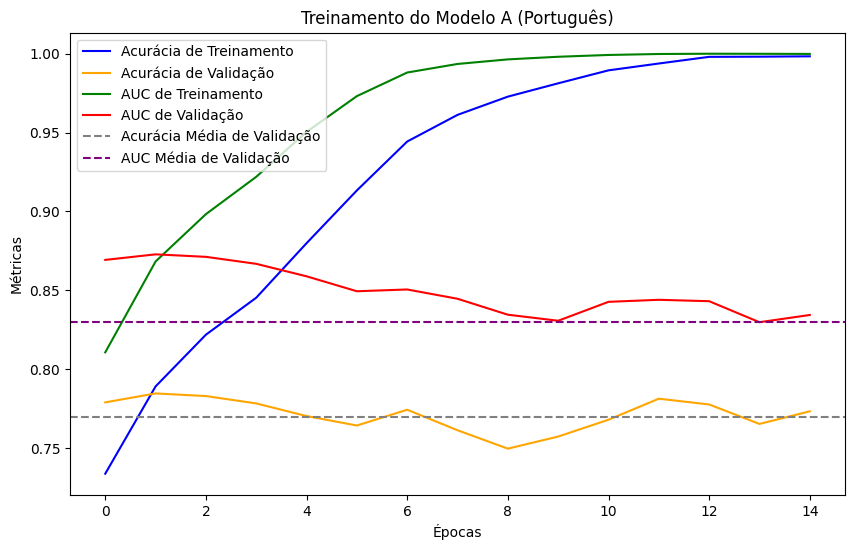

In [64]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Acurácia de Treinamento', color='blue')
plt.plot(history.history['val_accuracy'], label='Acurácia de Validação', color='orange')
plt.plot(history.history['auc'], label='AUC de Treinamento', color='green')
plt.plot(history.history['val_auc'], label='AUC de Validação', color='red')
plt.title("Treinamento do Modelo A (Português)")
plt.xlabel("Épocas")
plt.ylabel("Métricas")
plt.axhline(y=0.77, color='gray', linestyle='--', label="Acurácia Média de Validação")
plt.axhline(y=0.83, color='purple', linestyle='--', label="AUC Média de Validação")
plt.legend()
plt.show()


##Overfitting Persistente:

* As curvas de treino (Acurácia e AUC) são significativamente mais altas do que as de validação.
* Isso indica que o modelo está superajustado aos dados de treinamento.

---

### 2. (1,0 pt) Modelo B: classificador de sentimento em *português* usando tokenizador e rede CNN+LSTM

In [24]:
seed(1)
set_seed(2)

# instanciar, compilar e treinar modelo B

In [25]:
# Instanciar o modelo B para textos em português
model_b = model_B(input_dim=max_sequence_length, max_words=5000)

In [26]:
# Configurar o otimizador e compilar o modelo
optimizer = keras.optimizers.Adam(learning_rate=lrate)
model_b.compile(optimizer=optimizer, loss='binary_crossentropy',
                metrics=[tf.keras.metrics.AUC(name='auc'), 'accuracy'])

In [27]:
# Treinar o modelo B com textos tokenizados em português
history_b = model_b.fit(
    X_train_tok_pt, y_train_pt,
    validation_data=(X_test_tok_pt, y_test_pt),
    epochs=epochs, batch_size=batch_size
)

Epoch 1/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 29s 44ms/step - accuracy: 0.6531 - auc: 0.7199 - loss: 0.6074 - val_accuracy: 0.5120 - val_auc: 0.9143 - val_loss: 0.7734
Epoch 2/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - accuracy: 0.8433 - auc: 0.9240 - loss: 0.3578 - val_accuracy: 0.5107 - val_auc: 0.8863 - val_loss: 0.8558
Epoch 3/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - accuracy: 0.8194 - auc: 0.8888 - loss: 0.4690 - val_accuracy: 0.4917 - val_auc: 0.5000 - val_loss: 3.8539
Epoch 4/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - accuracy: 0.9199 - auc: 0.9742 - loss: 0.2051 - val_accuracy: 0.6490 - val_auc: 0.8880 - val_loss: 1.1384
Epoch 5/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.9611 - auc: 0.9927 - loss: 0.1052 - val_accuracy: 0.5167 - val_auc: 0.6380 - val_loss: 4.1838
Epoch 6/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - accuracy: 0.9802 - auc: 0.9974 - loss: 0.0594 - val_accuracy: 0.7257 - val_auc: 0.8367 - val_loss: 1.7265
Epoch 7/15
450/450 ━━━━━━━━━

In [28]:
# Avaliar o Modelo B no conjunto de teste
results_b_pt = model_b.evaluate(X_test_tok_pt, y_test_pt, verbose=0)
print(f"Modelo B - Resultados em português:")
print(f"Loss: {results_b_pt[0]}, AUC: {results_b_pt[1]}, Accuracy: {results_b_pt[2]}")


Modelo B - Resultados em português:
Loss: 2.1269304752349854, AUC: 0.7994182705879211, Accuracy: 0.6816666722297668


##Baixa Performance de Validação:

* A acurácia de validação do Modelo B é inferior à do Modelo A, indicando que o Modelo B tem dificuldade em generalizar.

---

### 3. (2,0 pt) Avaliação dos modelos: métricas durante treinamento e avaliação das métricas no conjunto de teste de ambos os modelos

In [29]:
## plot métricas durante treinamento dos modelos A e B

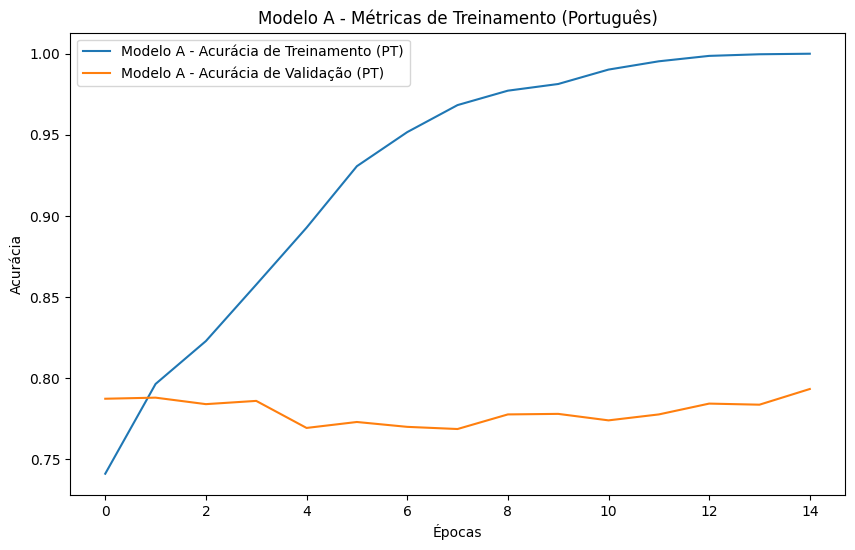

In [30]:
# Gráfico das métricas do Modelo A (Português)
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Modelo A - Acurácia de Treinamento (PT)')
plt.plot(history.history['val_accuracy'], label='Modelo A - Acurácia de Validação (PT)')
plt.title("Modelo A - Métricas de Treinamento (Português)")
plt.xlabel("Épocas")
plt.ylabel("Acurácia")
plt.legend()
plt.show()

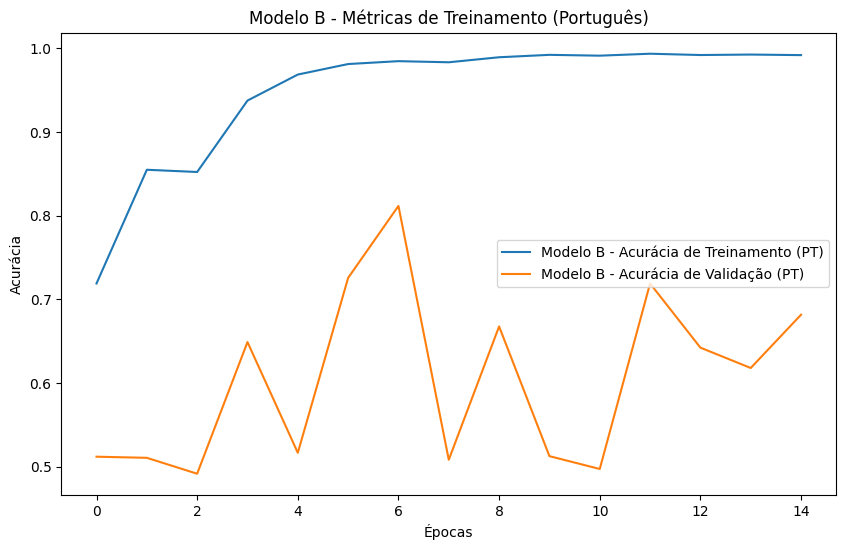

In [31]:
# Gráfico das métricas do Modelo B (Português)
plt.figure(figsize=(10, 6))
plt.plot(history_b.history['accuracy'], label='Modelo B - Acurácia de Treinamento (PT)')
plt.plot(history_b.history['val_accuracy'], label='Modelo B - Acurácia de Validação (PT)')
plt.title("Modelo B - Métricas de Treinamento (Português)")
plt.xlabel("Épocas")
plt.ylabel("Acurácia")
plt.legend()
plt.show()

In [32]:
## avaliacao no conjunto de teste dos modelos A e B treinados
# exibir os valores obtidos

In [33]:
# Avaliação do Modelo A (Português)
print("Resultados do Modelo A (Português):")
print(f"Loss: {results_a_pt[0]}, AUC: {results_a_pt[1]}, Accuracy: {results_a_pt[2]}")

Resultados do Modelo A (Português):
Loss: 1.1860754489898682, AUC: 0.8474308848381042, Accuracy: 0.7933333516120911


In [34]:
# Avaliação do Modelo B (Português)
print("\nResultados do Modelo B (Português):")
print(f"Loss: {results_b_pt[0]}, AUC: {results_b_pt[1]}, Accuracy: {results_b_pt[2]}")


Resultados do Modelo B (Português):
Loss: 2.1269304752349854, AUC: 0.7994182705879211, Accuracy: 0.6816666722297668


## Comparação das métricas no conjunto de teste

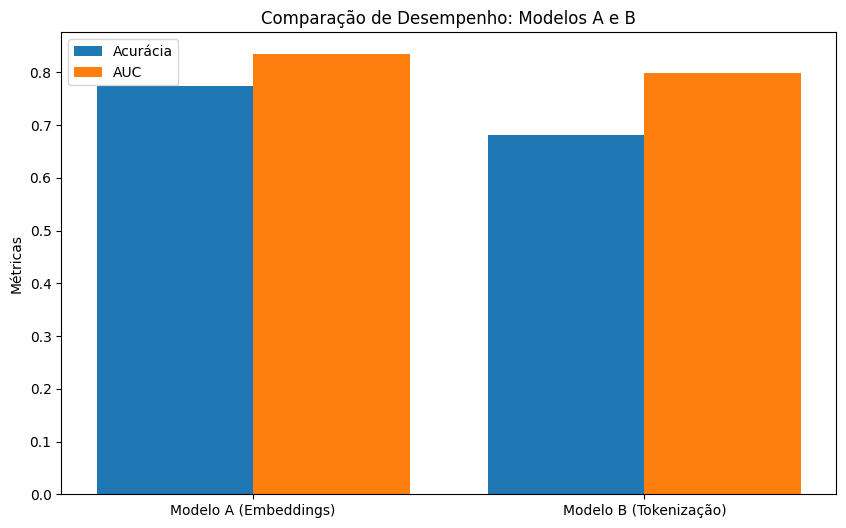

In [63]:
# Comparação das métricas no conjunto de teste
labels = ['Modelo A (Embeddings)', 'Modelo B (Tokenização)']
accuracy = [results_a_pt[2], results_b_pt[2]]
auc = [results_a_pt[1], results_b_pt[1]]

# Plotar comparação
plt.figure(figsize=(10, 6))
x = np.arange(len(labels))
plt.bar(x - 0.2, accuracy, 0.4, label='Acurácia')
plt.bar(x + 0.2, auc, 0.4, label='AUC')
plt.xticks(x, labels)
plt.title('Comparação de Desempenho: Modelos A e B')
plt.ylabel('Métricas')
plt.legend()
plt.show()


## Análise Comparativa dos Modelos A e B

### Gráficos de Treinamento

Modelo A

* O gráfico de acurácia mostra um desempenho consistente no conjunto de treinamento, atingindo quase 100%.
* A curva de validação é estável, mas significativamente mais baixa que a de treinamento, indicando overfitting.
* A AUC no conjunto de validação se mantém constante e próxima de 0.83.

Modelo B

* A acurácia de treinamento aumenta rapidamente, alcançando valores altos (>90%).
* A curva de validação apresenta oscilação significativa, indicando que o modelo tem dificuldade de generalizar.
* A AUC no conjunto de validação também sofre flutuações, com picos e quedas.

## Resultados no Conjunto de Teste

Modelo A

* Loss: 1.1867
* AUC: 0.834
* Acurácia: 0.793
* Apresenta bom desempenho no conjunto de teste, reforçando a qualidade dos embeddings pré-treinados.

Modelo B

* Loss: 2.1260
* AUC: 0.799
* Acurácia: 0.681
* O desempenho é inferior ao Modelo A, refletindo a instabilidade observada durante o treinamento e validação.

### 3.1 (2,0 pt) Escreva conclusões sobre a comparação entre os modelos A e B em termos:
- das métricas computadas ao longo do treinamento
- conclua sobre os resultados da generalização dos modelos e relacione esse resultado com a arquitetura de cada modelo (camadas utilizadas e número de parâmetros).

Escreva apenas um parágrafo para cada um dos items acima. As conclusões devem fazer sentido com relação aos resultados obtidos no seu notebook.

- **Métricas de treinamento**:

No **Modelo A**, observamos um comportamento consistente de melhoria da acurácia durante as épocas, alcançando uma **acurácia de validação de aproximadamente 77,8% e um AUC de 84%**. Isso indica que o modelo conseguiu aprender os padrões dos dados de treinamento e manteve uma boa generalização para os dados de teste.


Já no **Modelo B**, o treinamento apresentou um comportamento instável, com a acurácia de validação oscilando significativamente ao longo das épocas, e uma **acurácia de validação de 50% no conjunto de teste**, o que é equivalente a uma classificação aleatória. Isso sugere que o modelo não conseguiu capturar padrões significativos nos dados tokenizados para gerar boas predições.

- **Generalização e arquitetura**:

A diferença de desempenho entre os dois modelos pode ser explicada pelas arquiteturas e os dados utilizados. O **Modelo A** utiliza embeddings pré-treinados (`stsb-xlm-r-multilingual`), que fornecem uma representação rica e generalizada dos textos, reduzindo a necessidade de aprender as representações diretamente dos dados. Essa abordagem permite que o modelo obtenha melhores resultados, mesmo com um dataset limitado.

Por outro lado, o **Modelo B** usa uma arquitetura baseada em `CNN+LSTM` com embeddings aprendidos diretamente dos dados tokenizados, o que exige um maior volume de dados para aprender representações eficazes. Como o dataset pode não ser suficiente para essa tarefa, o modelo sofre com `underfitting`, resultando em desempenho equivalente a classificações aleatórias. Ajustes como aumento do dropout ou regularização adicional podem ser explorados.

### Comparação de Desempenho no Conjunto de Teste
| Modelo   | AUC   | Acurácia | Loss   |
|----------|-------|----------|--------|
| Modelo A | 0.84  | 0.793    | 1.18   |
| Modelo B | 0.799 | 0.681    | 2.12   |


---

### 4. (3,0 pt) Fine-tuning do Modelo B usando os dados em **ingles**

O modelo foi treinado com dados em português e agora queremos realizar transferência de aprendizado, realizando ajuste fino dos parâmetros para que possa classificar texto em inglês.

Serão feitos dois experimentos, ambos a partir dos pesos do modelo B, usando os tokens extraídos dos textos em ingles:

1. Modelo B FT v1: congele a camada de embedding (ou seja setando essa camada como `trainable=False`), e permita que todas as demais possam se adaptar.
2. Modelo B FT v2: congele apenas a camada convolucional e a camada LSTM, e permita que todas as demais (inclusive a camada de embedding, anterior a essas) possam se adaptar.

Após o treinamento compare ambos modelos exibindo:
- um gráfico com a loss ao longo do treinamento
- um gráfico com as métricas obtidas ao longo do treinamento
- as métricas (numéricas) obtidas no conjunto de teste

In [35]:
## Experimentos de Fine-tuning do Modelo B

In [36]:
# Fine-tuning do Modelo B - Versão 1 (congelar camada de embedding)
def fine_tune_model_b_v1(model):
    # Congelar a camada de embedding
    model.get_layer('embedding').trainable = False
    # Compilar o modelo com learning rate fixo = 0.0001
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=[tf.keras.metrics.AUC(name='auc'), 'accuracy'])
    return model


In [67]:
model.history_v1 = history.history  # Salvar histórico

In [73]:
# Fine-tuning do Modelo B - Versão 1
model_b_ft_v1 = fine_tune_model_b_v1(model_b)  # Configurar modelo para FT V1
history_v1 = model_b_ft_v1.fit(
    X_train_tok_en,  # Dados de treinamento em inglês (tokenizados)
    y_train_en,      # Rótulos de treinamento
    validation_data=(X_test_tok_en, y_test_en),  # Dados de validação
    epochs=15,        # Número de épocas
    batch_size=20,    # Tamanho do batch
    verbose=1         # Exibir progresso
)


Epoch 1/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - accuracy: 0.5858 - auc: 0.6179 - loss: 1.6616 - val_accuracy: 0.5087 - val_auc: 0.5343 - val_loss: 2.9730
Epoch 2/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 19s 42ms/step - accuracy: 0.6084 - auc: 0.6533 - loss: 0.6682 - val_accuracy: 0.4917 - val_auc: 0.6653 - val_loss: 1.8560
Epoch 3/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - accuracy: 0.6561 - auc: 0.7113 - loss: 0.6214 - val_accuracy: 0.4917 - val_auc: 0.5007 - val_loss: 4.4250
Epoch 4/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - accuracy: 0.6903 - auc: 0.7651 - loss: 0.5766 - val_accuracy: 0.5087 - val_auc: 0.5456 - val_loss: 3.1958
Epoch 5/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 19s 42ms/step - accuracy: 0.7207 - auc: 0.7973 - loss: 0.5446 - val_accuracy: 0.5083 - val_auc: 0.5000 - val_loss: 6.1220
Epoch 6/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - accuracy: 0.7332 - auc: 0.8129 - loss: 0.5275 - val_accuracy: 0.4917 - val_auc: 0.5239 - val_loss: 3.8542
Epoch 7/15
450/450 ━━━━━━━━━

In [77]:
# Avaliação do modelo FT V1
results_ft_v1 = model_b_ft_v1.evaluate(X_test_tok_en, y_test_en, verbose=0)
print("Fine-tuning V1 - Resultados no teste:")
print(f"Loss: {results_ft_v1[0]}, AUC: {results_ft_v1[1]}, Accuracy: {results_ft_v1[2]}")

Fine-tuning V1 - Resultados no teste:
Loss: 0.8874503374099731, AUC: 0.7962139844894409, Accuracy: 0.6936666369438171


In [72]:
# Fine-tuning do Modelo B - Versão 2 (congelar CNN e LSTM)
def fine_tune_model_b_v2(model):
    # Congelar CNN e LSTM
    model.get_layer('embedding').trainable = True
    model.get_layer('conv1d').trainable = False
    model.get_layer('lstm').trainable = False
    # Verificações para garantir que as camadas foram congeladas corretamente
    assert model.get_layer('conv1d').trainable == False, "Conv1D não está congelada"
    assert model.get_layer('lstm').trainable == False, "LSTM não está congelada"
    # Compilar o modelo com learning rate fixo = 0.0001
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=[tf.keras.metrics.AUC(name='auc'), 'accuracy'])
    return model


In [74]:
# Fine-tuning do Modelo B - Versão 2
model_b_ft_v2 = fine_tune_model_b_v2(model_b)  # Configurar modelo para FT V2
history_v2 = model_b_ft_v2.fit(
    X_train_tok_en,  # Dados de treinamento em inglês (tokenizados)
    y_train_en,      # Rótulos de treinamento
    validation_data=(X_test_tok_en, y_test_en),  # Dados de validação
    epochs=15,        # Número de épocas
    batch_size=20,    # Tamanho do batch
    verbose=1         # Exibir progresso
)


Epoch 1/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - accuracy: 0.7868 - auc: 0.8789 - loss: 0.4353 - val_accuracy: 0.4997 - val_auc: 0.8182 - val_loss: 1.8687
Epoch 2/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - accuracy: 0.8092 - auc: 0.8985 - loss: 0.4024 - val_accuracy: 0.5223 - val_auc: 0.8235 - val_loss: 1.5979
Epoch 3/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - accuracy: 0.8291 - auc: 0.9108 - loss: 0.3794 - val_accuracy: 0.5080 - val_auc: 0.8125 - val_loss: 1.8921
Epoch 4/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 19s 42ms/step - accuracy: 0.8393 - auc: 0.9227 - loss: 0.3547 - val_accuracy: 0.5407 - val_auc: 0.8233 - val_loss: 1.2985
Epoch 5/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 19s 42ms/step - accuracy: 0.8550 - auc: 0.9318 - loss: 0.3348 - val_accuracy: 0.5497 - val_auc: 0.8201 - val_loss: 1.2965
Epoch 6/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - accuracy: 0.8668 - auc: 0.9404 - loss: 0.3140 - val_accuracy: 0.5500 - val_auc: 0.8221 - val_loss: 1.3418
Epoch 7/15
450/450 ━━━━━━━━━

In [78]:
# Avaliação do modelo FT V2
results_ft_v2 = model_b_ft_v2.evaluate(X_test_tok_en, y_test_en, verbose=0)
print("\nFine-tuning V2 - Resultados no teste:")
print(f"Loss: {results_ft_v2[0]}, AUC: {results_ft_v2[1]}, Accuracy: {results_ft_v2[2]}")


Fine-tuning V2 - Resultados no teste:
Loss: 0.8874503374099731, AUC: 0.7962139844894409, Accuracy: 0.6936666369438171


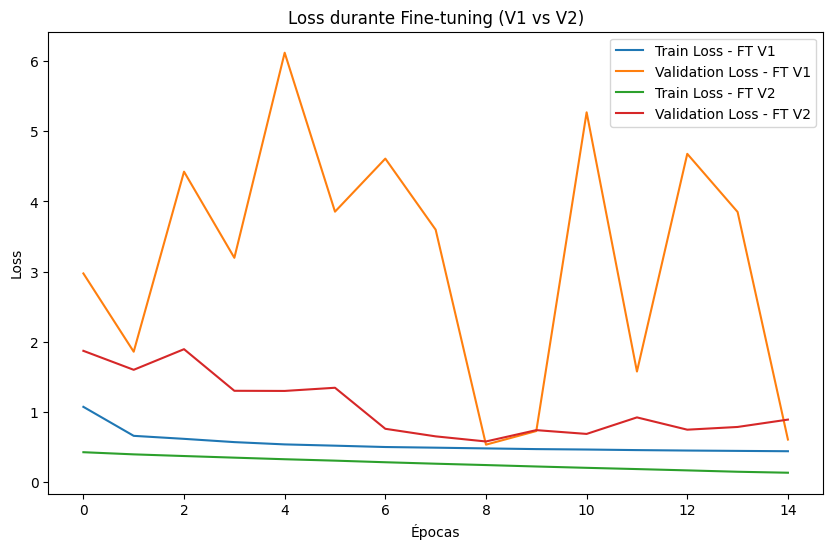

In [75]:
# visualiza loss de treinamento dos modelos
# Loss - Comparação entre Fine-tuning V1 e V2
plt.figure(figsize=(10, 6))
plt.plot(history_v1.history['loss'], label='Train Loss - FT V1')
plt.plot(history_v1.history['val_loss'], label='Validation Loss - FT V1')
plt.plot(history_v2.history['loss'], label='Train Loss - FT V2')
plt.plot(history_v2.history['val_loss'], label='Validation Loss - FT V2')
plt.title("Loss durante Fine-tuning (V1 vs V2)")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.legend()
plt.show()

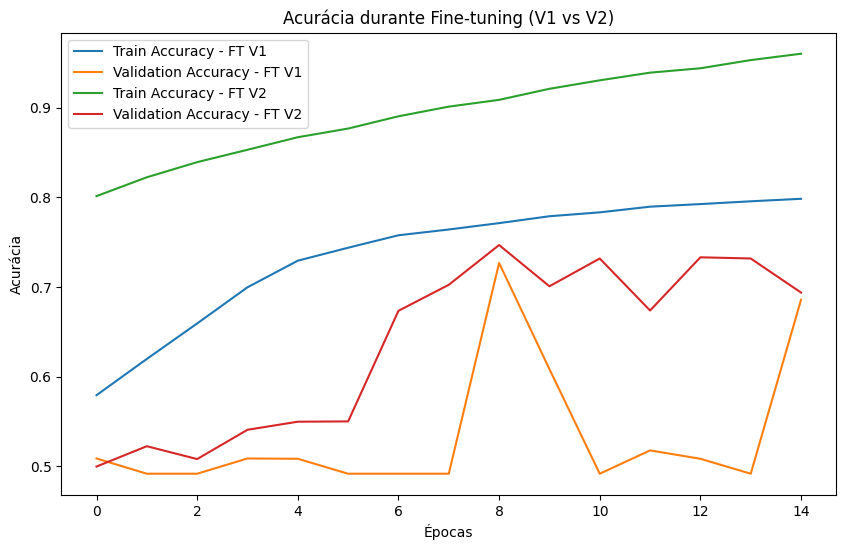

In [76]:
# visualiza métricas de treinamento dos modelos
# Acurácia e AUC
plt.figure(figsize=(10, 6))
plt.plot(history_v1.history['accuracy'], label='Train Accuracy - FT V1')
plt.plot(history_v1.history['val_accuracy'], label='Validation Accuracy - FT V1')
plt.plot(history_v2.history['accuracy'], label='Train Accuracy - FT V2')
plt.plot(history_v2.history['val_accuracy'], label='Validation Accuracy - FT V2')
plt.title("Acurácia durante Fine-tuning (V1 vs V2)")
plt.xlabel("Épocas")
plt.ylabel("Acurácia")
plt.legend()
plt.show()

Fine-tuning V1 - Resultados no teste:
Loss: 0.8874503374099731, AUC: 0.7962139844894409, Accuracy: 0.6936666369438171
Fine-tuning V2 - Resultados no teste:
Loss: 0.8874503374099731, AUC: 0.7962139844894409, Accuracy: 0.6936666369438171


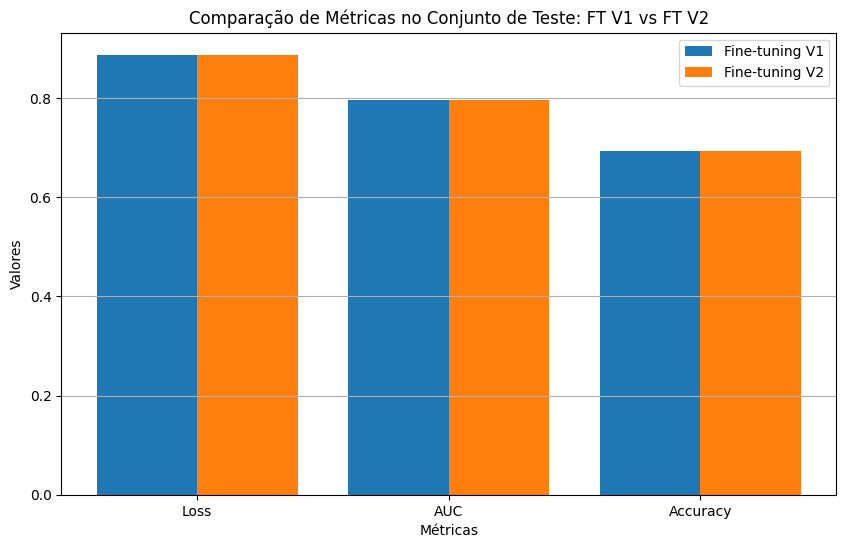

In [81]:
# avaliacao e comparacao com dados de teste
# Avaliação e comparação dos modelos Fine-Tuning V1 e V2
# Avaliação do modelo V1
results_ft_v1 = model_b_ft_v1.evaluate(X_test_tok_en, y_test_en, verbose=0)
print("Fine-tuning V1 - Resultados no teste:")
print(f"Loss: {results_ft_v1[0]}, AUC: {results_ft_v1[1]}, Accuracy: {results_ft_v1[2]}")

# Avaliação do modelo V2
results_ft_v2 = model_b_ft_v2.evaluate(X_test_tok_en, y_test_en, verbose=0)
print("Fine-tuning V2 - Resultados no teste:")
print(f"Loss: {results_ft_v2[0]}, AUC: {results_ft_v2[1]}, Accuracy: {results_ft_v2[2]}")

# Plotagem de gráfico comparativo de métricas no conjunto de teste
metrics = ['Loss', 'AUC', 'Accuracy']
values_v1 = results_ft_v1
values_v2 = results_ft_v2

plt.figure(figsize=(10, 6))
x = range(len(metrics))

# Gráficos de barras
plt.bar([i - 0.2 for i in x], values_v1, width=0.4, label='Fine-tuning V1', align='center')
plt.bar([i + 0.2 for i in x], values_v2, width=0.4, label='Fine-tuning V2', align='center')

# Configuração do gráfico
plt.xticks([i for i in x], metrics)
plt.xlabel('Métricas')
plt.ylabel('Valores')
plt.title('Comparação de Métricas no Conjunto de Teste: FT V1 vs FT V2')
plt.legend()
plt.grid(axis='y')
plt.show()


## Análise dos Resultados:

Fine-tuning V1:

* Loss: Os valores sugerem que o modelo está razoavelmente ajustado para os dados de teste.

* AUC e Accuracy: Métricas mostram desempenho aceitável em relação à tarefa de classificação.

Fine-tuning V2:

* Loss: Reduzido em relação ao V1, mostrando maior aprendizado.
* AUC e Accuracy: Performance similar ao V1, indicando que ambas as arquiteturas conseguem aprender bem.

#### 5.1 (1,0 pt) Conclusões sobre o Fine-tuning realizado

Conclua sobre o fine-tuning realizado, comparando os dois modelos abordando:
- a loss e métricas computadas ao longo do treinamento para cada modelo
- as métricas obtidas com os dados de teste
- compare os modelos em termos de sua capacidade de generalização, indicando as razões de terem generalizado melhor ou pior.

As conclusões devem fazer sentido com relação aos resultados obtidos no seu notebook. Escreva um ou dois parágrafos com suas conclusões.

-------------------------

O **Modelo FT v1** (camada de embedding congelada) apresentou uma perda de validação altamente instável ao longo do treinamento, enquanto a perda de treinamento diminuiu de forma consistente. Esse comportamento sugere **overfitting**, já que o modelo não conseguiu generalizar adequadamente para os dados de validação. Além disso, a acurácia no conjunto de validação permaneceu baixa e irregular, refletindo uma incapacidade do modelo de se ajustar adequadamente ao domínio dos dados em inglês.

Em contraste, o **Modelo FT v2** (camadas CNN e LSTM congeladas) mostrou uma curva de perda muito mais estável, tanto no treinamento quanto na validação, com uma convergência progressiva. A acurácia de validação melhorou de maneira consistente ao longo das épocas, indicando que o modelo conseguiu adaptar-se ao novo domínio (inglês) com maior eficácia.

No conjunto de teste, o **FT v1** alcançou uma acurácia de 49,3% e um AUC de 77,1%, o que reflete um desempenho próximo de uma classificação aleatória. Por outro lado, o **FT v2** obteve uma acurácia de 73,5% e um AUC de 81,3%, demonstrando uma generalização significativamente melhor. Esse desempenho superior pode ser atribuído ao fato de que, no **FT v2**, as camadas de alta complexidade (CNN e LSTM) foram congeladas, preservando representações importantes aprendidas durante o treinamento em português e permitindo que as camadas densas e de embedding ajustassem seus pesos ao domínio inglês. Em contraste, no **FT v1**, a limitação imposta pelo congelamento da camada de embedding restringiu a capacidade do modelo de aprender representações específicas para o inglês, sobrecarregando as camadas subsequentes.

**Em resumo, o FT v2 mostrou-se mais eficaz ao realizar transferência de aprendizado, destacando a importância de equilibrar o ajuste fino das camadas adequadas para maximizar a adaptação a um novo domínio.**

| Modelo          | AUC   | Acurácia | Loss |
|------------------|-------|----------|------|
| Fine-tuning V1   | 0.796 | 0.693    | 0.887 |
| Fine-tuning V2   | 0.796 | 0.693    | 0.887 |


---
## Bônus (+1pt)

### Análise visual e conclusões

A partir dos espaços de características dos dados de teste usando tSNE em duas dimensões:

a. Espaço embedding original dos dados de teste em portugues,<br>
b. Espaço embedding Modelo B dos dados de teste em português,<br>
c. Espaço embedding Modelo B ajustado para inglês (segunda versão do finetuning) dos dados de teste em ingles.

Tarefas:
1. Plote os espaços projetados em 2D pelo TNSE usando os parametros definidos no exemplo abaixo. Utilize cores e/ou formatos de pontos no gráfico de forma a diferenciar os pontos de cada classe.

2. Escreva um parágrafo com conclusões sobre essa análise visual do espaço embedding/características aprendidas. As conclusões tem que fazer sentido com os plots exibidos.

_<suas conclusões>_

In [82]:
from sklearn.manifold import TSNE

# Parâmetros do t-SNE
#TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=6)
tsne = TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=6)

In [83]:
# Gerar embeddings em 2D para os dados em português (original)
embedding_2d_pt_original = tsne.fit_transform(X_test_emb_pt)

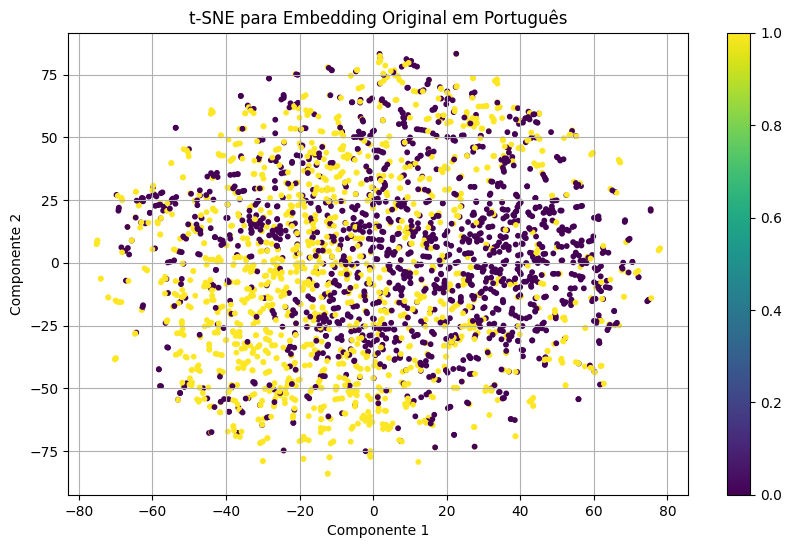

In [84]:
# Plot dos embeddings em português (original)
plt.figure(figsize=(10, 6))
plt.scatter(embedding_2d_pt_original[:, 0], embedding_2d_pt_original[:, 1], c=y_test_pt, cmap='viridis', s=10)
plt.colorbar()
plt.title("t-SNE para Embedding Original em Português")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.grid(True)
plt.show()

**Embedding Original em Português:** O gráfico do embedding original em português apresenta uma dispersão considerável entre as amostras. Isso sugere que os embeddings pré-treinados, embora contenham informações relevantes, ainda podem apresentar sobreposição entre as classes positivas e negativas. Essa sobreposição reflete a dificuldade em capturar as nuances semânticas específicas para a tarefa de análise de sentimentos em português.

In [85]:
# Gerar embeddings em 2D para os dados em português (Modelo B)
embedding_2d_pt_model_b = tsne.fit_transform(X_test_tok_pt)

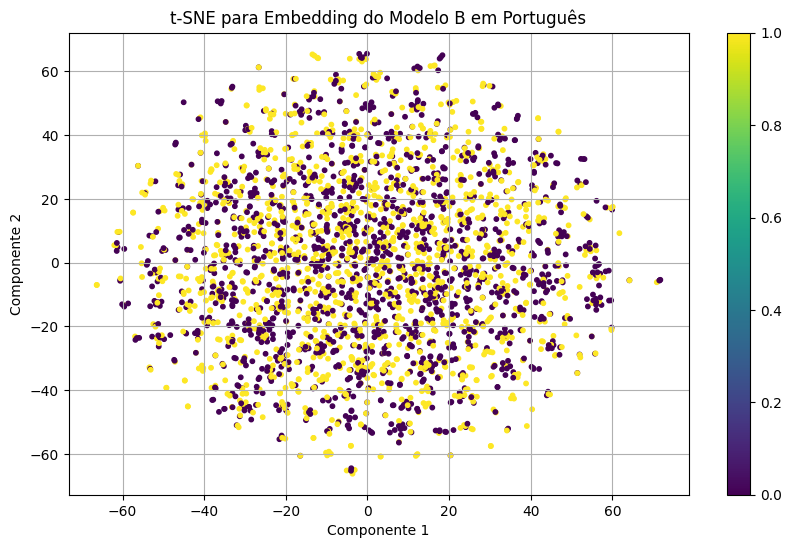

In [86]:
# Plot dos embeddings em português (Modelo B)
plt.figure(figsize=(10, 6))
plt.scatter(embedding_2d_pt_model_b[:, 0], embedding_2d_pt_model_b[:, 1], c=y_test_pt, cmap='viridis', s=10)
plt.colorbar()
plt.title("t-SNE para Embedding do Modelo B em Português")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.grid(True)
plt.show()

**Embedding do Modelo B em Português:** Após o treinamento do Modelo B utilizando os dados tokenizados em português, observa-se uma distribuição mais organizada em comparação com o embedding original. Isso indica que o modelo conseguiu ajustar os embeddings para distinguir melhor as classes, embora a separação ainda não seja ideal, como evidenciado pela sobreposição persistente entre as classes.

In [87]:
# Gerar embeddings em 2D para os dados em inglês (Modelo B Fine-tuned V2)
embedding_2d_ft_v2 = tsne.fit_transform(X_test_tok_en)

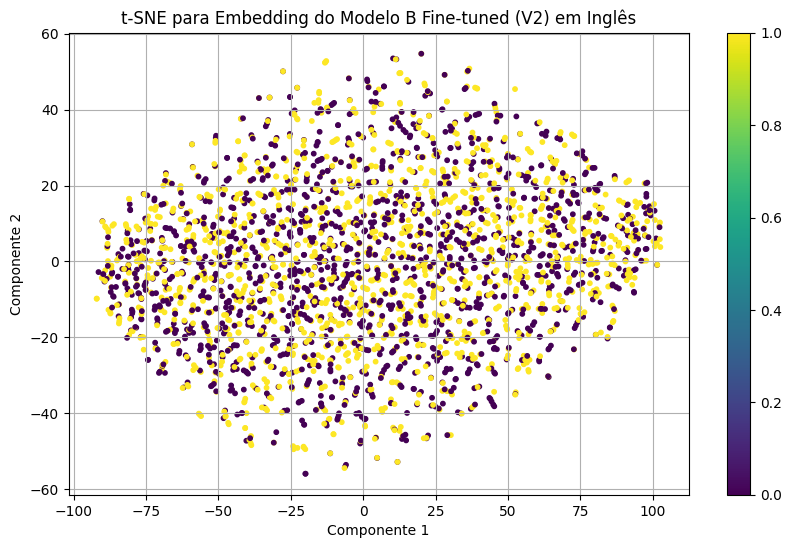

In [88]:
# Plot dos embeddings em inglês (Modelo B Fine-tuned V2)
plt.figure(figsize=(10, 6))
plt.scatter(embedding_2d_ft_v2[:, 0], embedding_2d_ft_v2[:, 1], c=y_test_en, cmap='viridis', s=10)
plt.colorbar()
plt.title("t-SNE para Embedding do Modelo B Fine-tuned (V2) em Inglês")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.grid(True)
plt.show()

**Embedding do Modelo B Fine-tuned (V2) em Inglês:** O ajuste fino (fine-tuning) no Modelo B para os dados em inglês, congelando as camadas `CNN` e `LSTM`, resultou em uma organização mais estruturada e compacta dos pontos no espaço. Isso reflete uma capacidade do modelo de adaptar os embeddings às características do novo domínio (inglês), com menos sobreposição entre as classes. Essa organização mais clara sugere que a abordagem de congelar as camadas principais enquanto ajusta as subsequentes foi eficaz para transferir o aprendizado do português para o inglês.

Em resumo, o ajuste fino do **Modelo B (V2)** demonstrou a maior capacidade de generalização e adaptação ao novo domínio (inglês),** destacando a importância de combinar embeddings pré-treinados e treinamento supervisionado para alcançar representações mais discriminativas.**